# 09 Exercises 2: WA state hourly data

UW Geospatial Data Analysis  
CEE467/CEWA567  
David Shean  

In [ ]:
import os
from glob import glob
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [ ]:
#curr_y = pd.to_datetime("today").year
curr_y = 2022

## Load the WA temperature, precipitation and snow depth products
* Note: these are extracted for 12:00 UTC
* Really want daily averages for much of this, but I didn't have time to go back and requery ERA5
* Let's use what we have to play around

In [ ]:
era5_datadir = '/home/jovyan/jupyterbook/book/modules/09_NDarrays_xarray_ERA5/era5_data'

In [ ]:
!ls -lh $era5_datadir

total 3.9G
-rw-r--r-- 1 jovyan users 2.0G Feb  4 05:48 1month_anomaly_Global_ea_2t.nc
-rw-r--r-- 1 jovyan users  48M Feb  4 05:48 climatology_0.25g_ea_2t.nc
-rw-r--r-- 1 jovyan users 1.9G Feb  4 05:48 WA_ERA5-Land_hourly_1950-2022_6hr.nc


In [ ]:
merge_fn = os.path.join(era5_datadir, 'WA_ERA5-Land_hourly_1950-2022_6hr.nc')

### Optional: start Dask cluster using Jupterlab interface, connect to client
* Please don't use during lab session, but feel free to experiment on your own
* Note this will use all CPUs on the shared node by default
* https://docs.xarray.dev/en/stable/user-guide/dask.html

In [ ]:
#Start from Jupyterlab, copy paste corresponding code

In [ ]:
#from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()  # Launches a scheduler and workers locally
#client = Client(cluster)  # Connect to distributed cluster and override default

In [ ]:
#Set up dask chunking
chunks = {'longitude':27, 'latitude':19}

In [ ]:
wa_merge = xr.open_dataset(merge_fn, chunks=chunks)

In [ ]:
wa_merge

<xarray.Dataset>
Dimensions:    (longitude: 81, latitude: 38, time: 105191)
Coordinates:
  * longitude  (longitude) float32 -124.8 -124.7 -124.6 ... -116.9 -116.8 -116.8
  * latitude   (latitude) float32 49.2 49.1 49.0 48.9 ... 45.8 45.7 45.6 45.5
  * time       (time) datetime64[ns] 1950-01-01T06:00:00 ... 2021-12-31T18:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(105191, 19, 27), meta=np.ndarray>
    sde        (time, latitude, longitude) float32 dask.array<chunksize=(105191, 19, 27), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(105191, 19, 27), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-28 10:58:20 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

In [ ]:
wa_merge['t2m'] -= 273.15
wa_merge['t2m'].attrs['units'] = 'C'

In [ ]:
#Convert meters to mm
wa_merge['tp'] *= 1000
wa_merge['tp'].attrs['units'] = 'mm'

In [ ]:
wa_merge['t2m']

<xarray.DataArray 't2m' (time: 105191, latitude: 38, longitude: 81)>
dask.array<sub, shape=(105191, 38, 81), dtype=float32, chunksize=(105191, 19, 27), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -124.8 -124.7 -124.6 ... -116.9 -116.8 -116.8
  * latitude   (latitude) float32 49.2 49.1 49.0 48.9 ... 45.8 45.7 45.6 45.5
  * time       (time) datetime64[ns] 1950-01-01T06:00:00 ... 2021-12-31T18:00:00
Attributes:
    units:      C
    long_name:  2 metre temperature

In [ ]:
wa_merge

<xarray.Dataset>
Dimensions:    (longitude: 81, latitude: 38, time: 105191)
Coordinates:
  * longitude  (longitude) float32 -124.8 -124.7 -124.6 ... -116.9 -116.8 -116.8
  * latitude   (latitude) float32 49.2 49.1 49.0 48.9 ... 45.8 45.7 45.6 45.5
  * time       (time) datetime64[ns] 1950-01-01T06:00:00 ... 2021-12-31T18:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(105191, 19, 27), meta=np.ndarray>
    sde        (time, latitude, longitude) float32 dask.array<chunksize=(105191, 19, 27), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(105191, 19, 27), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-28 10:58:20 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

In [ ]:
#Unset units (avoid plotting in x and y label)
wa_merge['latitude'].attrs['units'] = None
wa_merge['longitude'].attrs['units'] = None

## Clip to WA state geometry

In [ ]:
#wa_merge_clip = wa_merge.rio.write_crs(wa_state.crs);
#wa_merge_clip = wa_merge_clip.rio.clip(wa_geom, crs=world.crs, drop=False)

## Compute seasonal mean values for each variable
* This may take ~30-60 seconds depending on chunks and server load
* This is a simple `groupby()` and `mean()`
* Inspect the output values - do these make sense?

In [ ]:
wa_merge_seasonal_mean = wa_merge.groupby('time.season').mean().compute()

In [ ]:
wa_merge_seasonal_mean

<xarray.Dataset>
Dimensions:    (longitude: 81, latitude: 38, season: 4)
Coordinates:
  * longitude  (longitude) float32 -124.8 -124.7 -124.6 ... -116.9 -116.8 -116.8
  * latitude   (latitude) float32 49.2 49.1 49.0 48.9 ... 45.8 45.7 45.6 45.5
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    t2m        (season, latitude, longitude) float32 0.9609 0.2696 ... 6.214
    sde        (season, latitude, longitude) float32 0.2804 0.3006 ... 0.02896
    tp         (season, latitude, longitude) float32 5.971 5.626 ... 1.292 1.302
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-28 10:58:20 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

In [ ]:
#Hack to reorder seasons, as default is alphabetical
#order = np.array(['DJF', 'MAM', 'JJA', 'SON'], dtype=object)
order = np.array([0,2,1,3])
#wa_merge_seasonal_mean.season.values
wa_merge_seasonal_mean = wa_merge_seasonal_mean.isel(season=order)

In [ ]:
#wa_merge_seasonal_resample = wa_merge.resample(time='Q-NOV').mean('time')

## Plot seasonal mean grids
* Note that plot will assume `x='longitude', y='latitude'`, but can also explicitly specify

In [ ]:
wa_merge_seasonal_mean.data_vars

Data variables:
    t2m      (season, latitude, longitude) float32 0.9609 0.2696 ... 6.408 6.214
    sde      (season, latitude, longitude) float32 0.2804 0.3006 ... 0.02896
    tp       (season, latitude, longitude) float32 5.971 5.626 ... 1.292 1.302

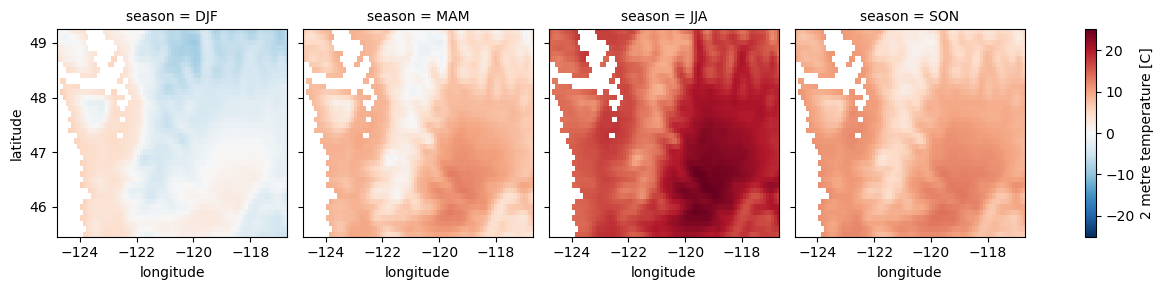

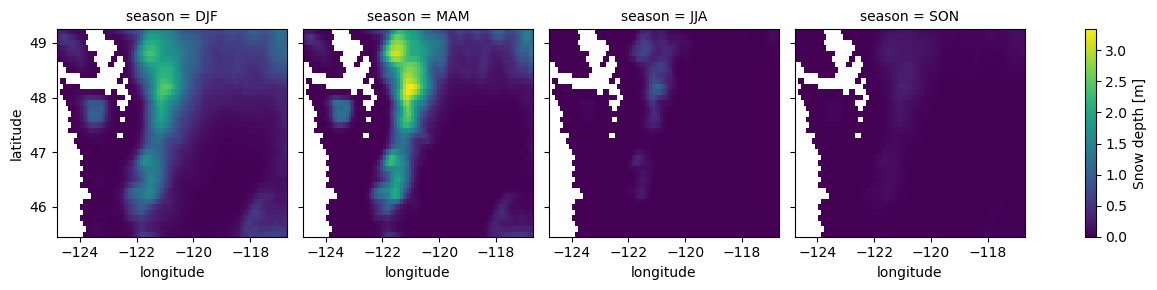

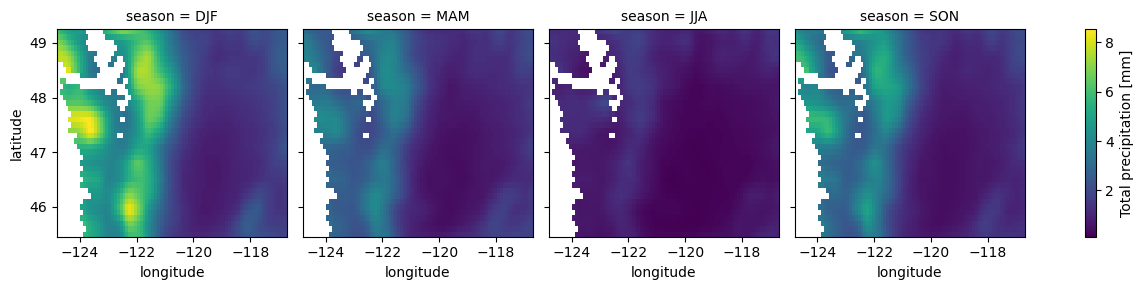

In [ ]:
for i in wa_merge_seasonal_mean.data_vars:
    wa_merge_seasonal_mean[i].plot.imshow(col='season')

## Compute mean monthly values for WA state

In [ ]:
wa_monthly_mean = wa_merge.groupby('time.month').mean('time').mean(['latitude','longitude']).compute()
wa_monthly_mean

<xarray.Dataset>
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    t2m      (month) float32 -1.957 0.09294 2.627 6.119 ... 8.671 2.257 -1.521
    sde      (month) float32 0.4876 0.5431 0.5326 ... 0.009246 0.08937 0.2947
    tp       (month) float32 3.241 2.678 2.378 1.75 ... 0.9946 1.997 3.257 3.394

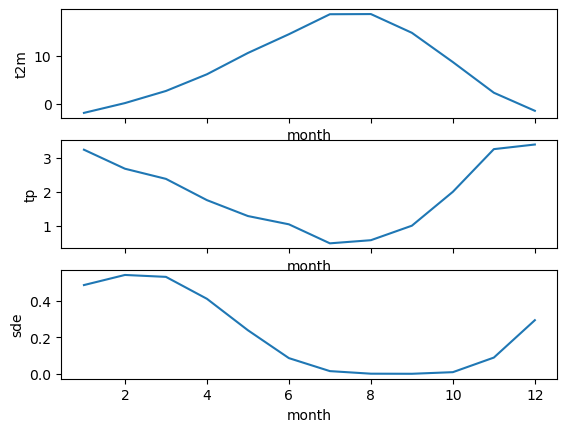

In [ ]:
f, axa = plt.subplots(3,1, sharex=True)
wa_monthly_mean['t2m'].plot(ax=axa[0])
wa_monthly_mean['tp'].plot(ax=axa[1])
wa_monthly_mean['sde'].plot(ax=axa[2]);

## Helper function for plotting WA grids with state outline overlay

In [ ]:
def plotwa(ds_in, v_list=['t2m','tp','sde'], op='mean'):
    f,axa = plt.subplots(1,3, figsize=(12,2), sharex=True, sharey=True)
    for i,v in enumerate(v_list):
        ds_in[v].plot(ax=axa[i], robust=True)
        wa_state.plot(ax=axa[i], facecolor='none', edgecolor='black')
        axa[i].set_title('WA State ERA5 Hourly: %s %s' % (op, v))
    f.tight_layout()

## Get the WA state outline

In [ ]:
#states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)

In [ ]:
wa_state = states_gdf.loc[states_gdf['NAME'] == 'Washington']

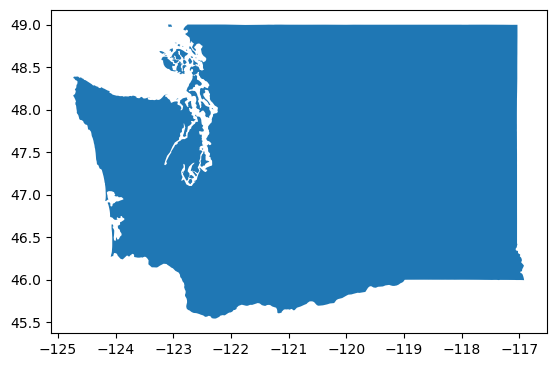

In [ ]:
wa_state.plot();

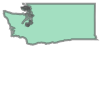

In [ ]:
wa_geom = wa_state.iloc[0].geometry
wa_geom

## Create some plots of descriptive stats (mean, max, min, std) for 1979-present
* Pass the relevant dataset (e.g. `wa_merge.mean('time')`) to the `plotwa` helper function
* What do these metrics tell you?
    * What is causing most of the temperature variability captured by the std?
    * What is the highest temperature value

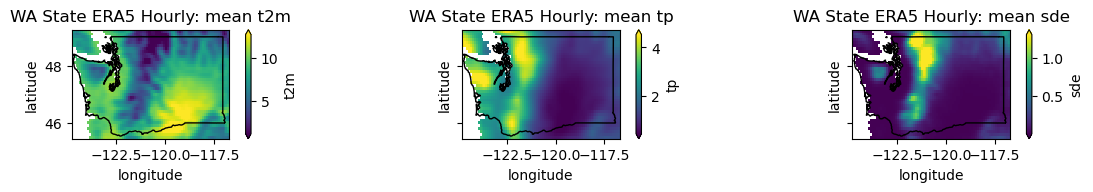

In [ ]:
plotwa(wa_merge.mean('time'), op='mean')

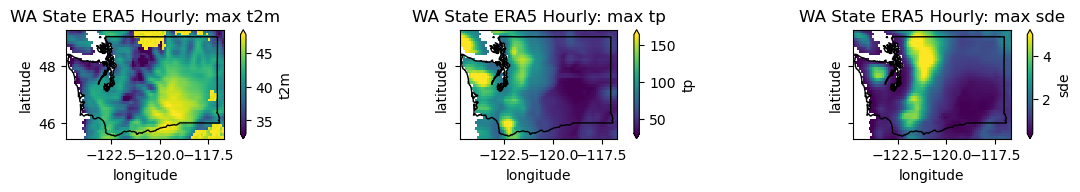

In [ ]:
plotwa(wa_merge.max('time'), op='max')

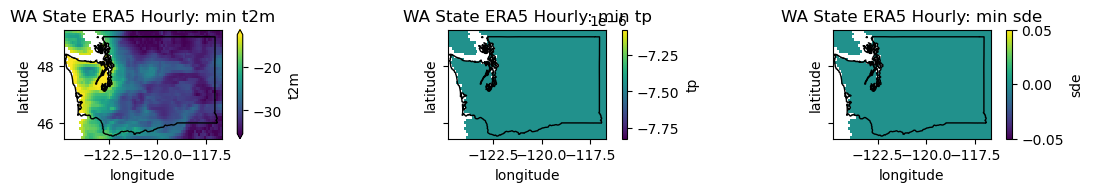

In [ ]:
plotwa(wa_merge.min('time'), op='min')

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


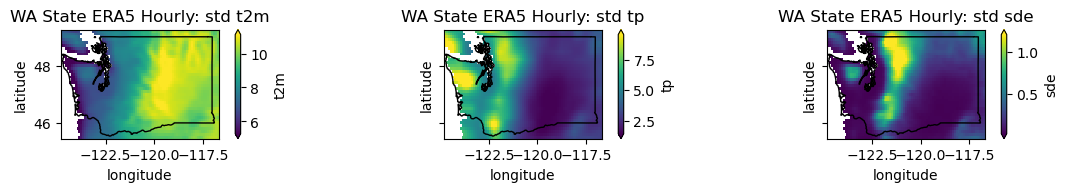

In [ ]:
plotwa(wa_merge.std('time'), op='std')

## Create a plot showing the conditions the day before and after the Mt. St. Helen's eruption

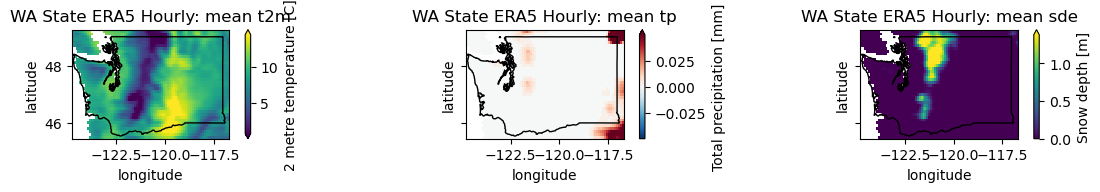

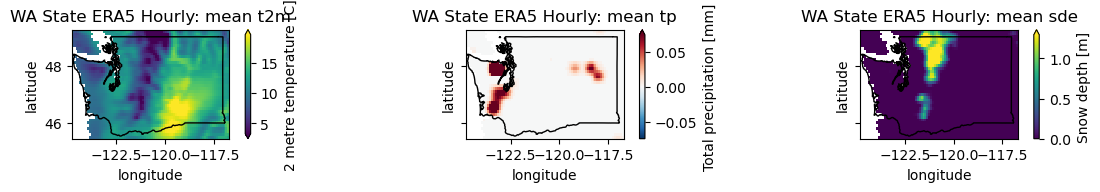

In [ ]:
pre = wa_merge.sel(time='1980-05-17T06:00')
plotwa(pre)
post = wa_merge.sel(time='1980-05-19T06:00')
plotwa(post)

## Create a plot showing the conditions during the June 2021 heat wave
* https://en.wikipedia.org/wiki/2021_Western_North_America_heat_wave
* Extra credit: prepare a map of the long-term average t2m for June 29, then difference against the t2m values from June 29, 2021

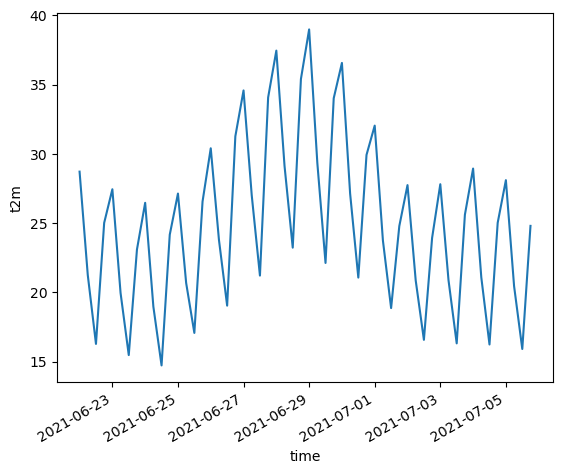

In [ ]:
wa_merge.t2m.sel(time=slice("2021-06-22", "2021-07-05")).mean(dim=('longitude', 'latitude')).plot()

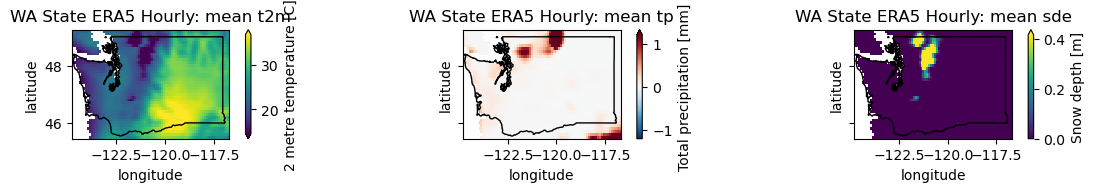

In [ ]:
plotwa(wa_merge.sel(time='2021-06-24T00:00'))

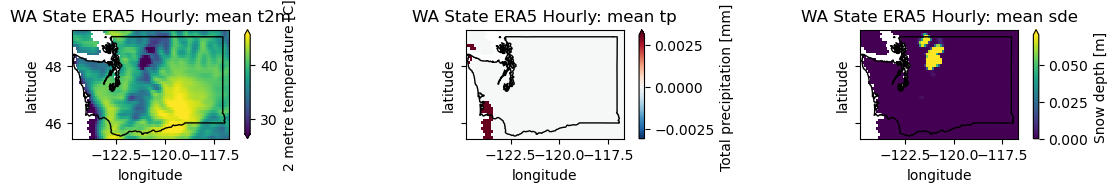

In [ ]:
plotwa(wa_merge.sel(time='2021-06-29T00:00'))

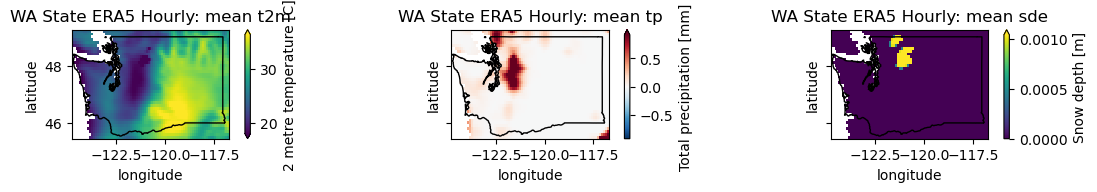

In [ ]:
plotwa(wa_merge.sel(time='2021-07-03T00:00'))

## Extract the time series for Seattle and Mt. Rainier temperature and create line plot
* You'll need to look up coordinates
    * Check the longitude system in the DataArrays (-180 to 180, or 0 to 360)
* Can use the `sel()` method to extract time series for the grid cell nearest the specified 'longitude' and 'latitude' coordinates
    * http://xarray.pydata.org/en/stable/indexing.html
    * Remember, these are large grid cells (~31x31 km), so one grid cell could cover the most of Mt. Rainier (a single temperature value that includes the cold summit and the warmer, lowland river valleys)
* Sanity check

In [ ]:
#sea_coord = (-122.25, 47.5)
sea_coord = (-122.3321, 47.6062)
rainier_coord = (121.7603, 46.8523)

In [ ]:
sea_ts = wa_merge.sel(longitude=sea_coord[0], latitude=sea_coord[1], method='nearest')
sea_ts

<xarray.Dataset>
Dimensions:    (time: 105191)
Coordinates:
    longitude  float32 -122.3
    latitude   float32 47.6
  * time       (time) datetime64[ns] 1950-01-01T06:00:00 ... 2021-12-31T18:00:00
Data variables:
    t2m        (time) float32 dask.array<chunksize=(105191,), meta=np.ndarray>
    sde        (time) float32 dask.array<chunksize=(105191,), meta=np.ndarray>
    tp         (time) float32 dask.array<chunksize=(105191,), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-28 10:58:20 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

In [ ]:
rainier_ts = wa_merge.sel(longitude=rainier_coord[0], latitude=rainier_coord[1], method='nearest')
rainier_ts

<xarray.Dataset>
Dimensions:    (time: 105191)
Coordinates:
    longitude  float32 -116.8
    latitude   float32 46.9
  * time       (time) datetime64[ns] 1950-01-01T06:00:00 ... 2021-12-31T18:00:00
Data variables:
    t2m        (time) float32 dask.array<chunksize=(105191,), meta=np.ndarray>
    sde        (time) float32 dask.array<chunksize=(105191,), meta=np.ndarray>
    tp         (time) float32 dask.array<chunksize=(105191,), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-28 10:58:20 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

In [ ]:
rainier_ts.time.values.min()

numpy.datetime64('1950-01-01T06:00:00.000000000')

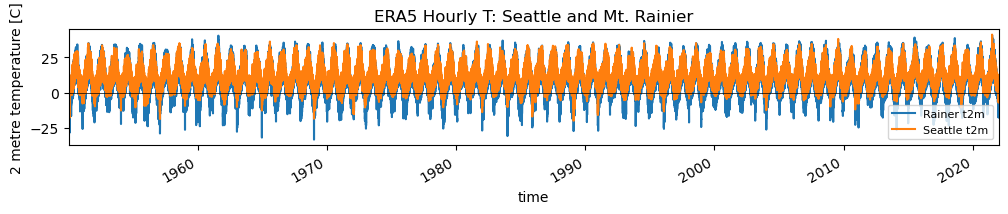

In [ ]:
f, ax = plt.subplots(figsize=(12,1.5))
v = 't2m'
rainier_ts[v].plot(ax=ax, label='Rainer %s' % v)
sea_ts[v].plot(ax=ax, label='Seattle %s' % v)
ax.axhline(0,color='k',lw=0.5)
ax.legend(fontsize=8)
ax.set_xlim(rainier_ts.time.values.min(), rainier_ts.time.values.max())
ax.set_title("ERA5 Hourly T: Seattle and Mt. Rainier");

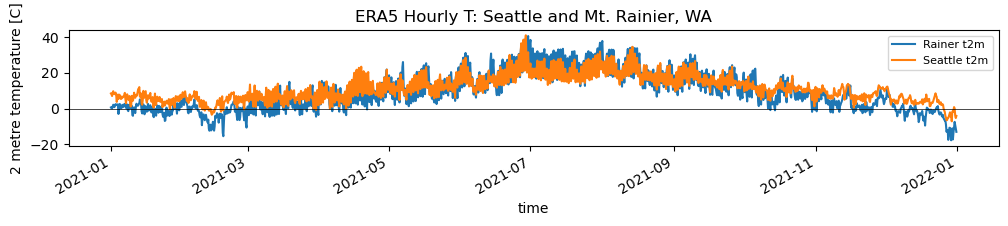

In [ ]:
f, ax = plt.subplots(figsize=(12,1.5))
v = 't2m'
rainier_ts[v].loc[f'{curr_y-1}-01-01':].plot(ax=ax, label='Rainer %s' % v)
sea_ts[v].loc[f'{curr_y-1}-01-01':].plot(ax=ax, label='Seattle %s' % v)
ax.axhline(0,color='k',lw=0.5)
ax.legend(fontsize=8)
ax.set_title("ERA5 Hourly T: Seattle and Mt. Rainier, WA");

## Helper function to plot time series

In [ ]:
def plotv(ds_in, v_list=['t2m','tp','sde']):
    f,axa = plt.subplots(3,1, figsize=(10,6), sharex=True)
    for i,v in enumerate(v_list):
        ds_in[v].dropna(dim='time').plot(ax=axa[i], lw=0.5)
        axa[i].axhline(0,color='k',lw=0.5)
    f.tight_layout()

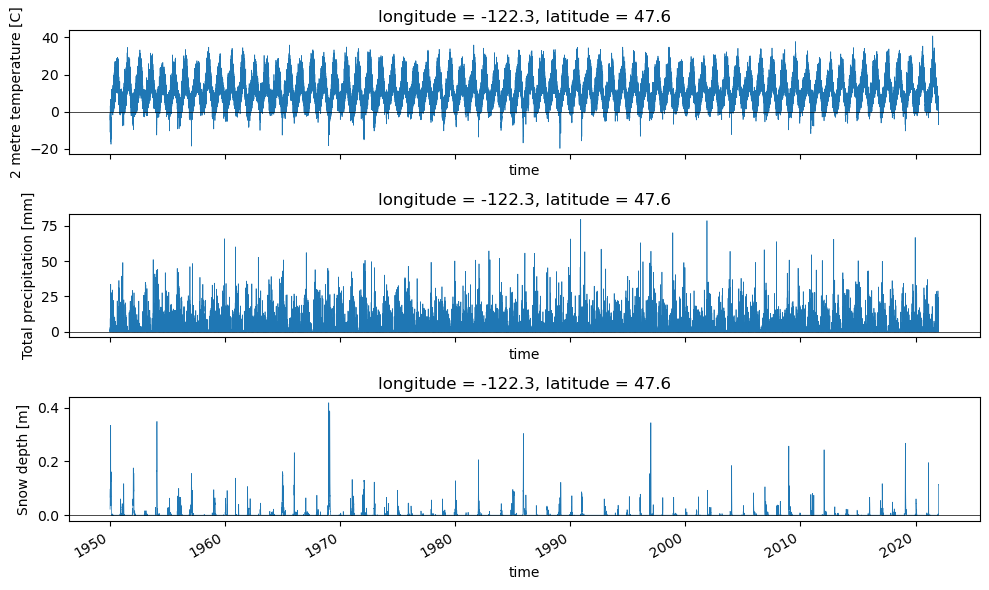

In [ ]:
plotv(wa_merge.sel(longitude=sea_coord[0], latitude=sea_coord[1], method='nearest'))

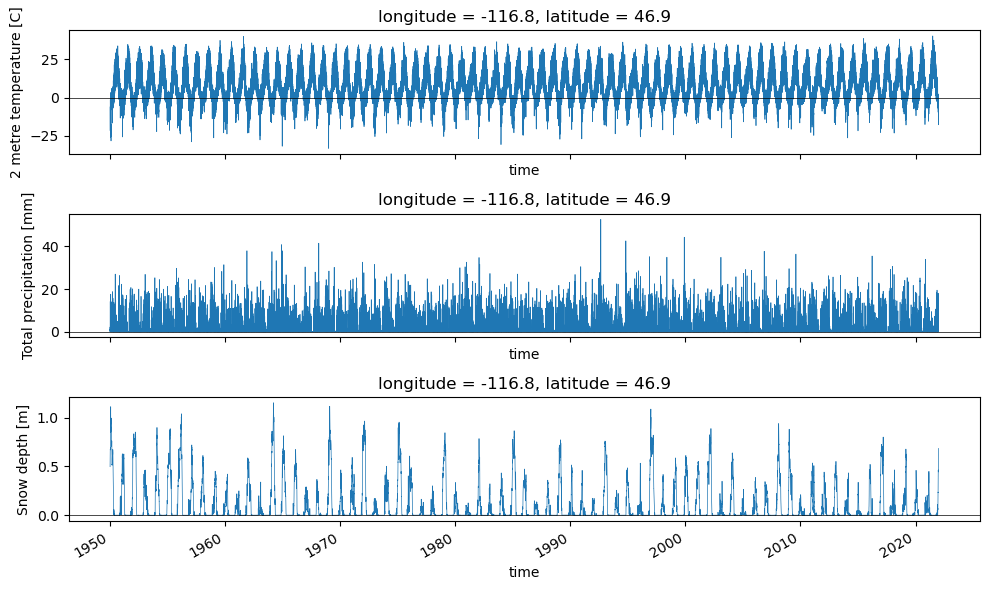

In [ ]:
plotv(wa_merge.sel(longitude=rainier_coord[0], latitude=rainier_coord[1], method='nearest'))

## Compute stats for monthly, annual time periods
* Can use `groupby('time.year').max(dim='time')`
* Plot snow depth for April and September

## Extra Credit: Create a map that shows the year containing the maximum T value at each grid cell
* These should mostly be in the most recent decade
* Note the `.compute()` is needed to converty dask array to ndarray for use in vectorized indexing

*Note from 2022 - the ERA5-Land products include some cells that are all nan over time (e.g., ocean). This creates problems for the xarray argmax function, even with skipna=True, and various dropna calls*

Need to revisit

In [ ]:
#wa_merge['t2m'].dropna(dim='time', how='all').argmax(dim='time').compute()
#wa_merge['t2m'].idxmax(dim='time').compute()
#xr.apply_ufunc(np.nanargmax, wa_merge['t2m'].load())

In [ ]:
#max_t_idx = wa_merge['t2m'].argmax(dim='time', skipna=True).compute()

In [ ]:
#f, ax = plt.subplots()
#wa_merge['t2m']['time.year'][max_t_idx].plot(ax=ax)
#wa_state.plot(ax=ax, facecolor='none', edgecolor='black');

In [ ]:
#wa_merge['t2m']['time.year'][max_t_idx].median()

# Extra Credit

## Export one of the derived WA grids to rasterio
* https://corteva.github.io/rioxarray/stable/examples/convert_to_raster.html#Converting-Dataset-to-raster
* https://xarray.pydata.org/en/stable/user-guide/io.html#rasterio
* https://github.com/robintw/XArrayAndRasterio/blob/master/rasterio_to_xarray.py

## Load SRTM DEM for WA
* Resample

## Plot contours from SRTM DEM over temperature grid

### Compute atmospheric temperature lapse rate using SRTM elevations

## Compute correlation between temperature and elevation
* https://github.com/pydata/xarray/issues/1115

## What if my data are too big?
* http://xarray.pydata.org/en/stable/dask.html